# Mixed (Numeric + Categorical) Regression — MLP & RNN → SHAP → STAT‑XAI

In [ ]:
# !pip install -q pandas numpy scikit-learn matplotlib shap scipy statsmodels torch psutil

In [1]:

from __future__ import annotations
import os, itertools
from typing import Sequence, Tuple
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap, statsmodels.api as sm, statsmodels.formula.api as smf
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [3]:

MODEL = "RNN"  # or "RNN"
DATA_PATH = "/Users/arsh/STAT-XAI/Datasets/Synthetic/Loan Approval Categorical Numerical Synthetic Dataset Continous Outcome.csv"
TARGET = "Approval_Probability"
NUMERIC_FEATURES = ['Annual_Income','Credit_Score','Employment_Length','Age','Loan_Term']
CATEGORICAL_FEATURES = ['Loan_Purpose','Employment_Status','Loan_Categories','Region','Marital_Status']
TEST_SIZE = 0.2; RANDOM_STATE = 42
EPOCHS_RNN=60; BATCH_TRAIN=64; BATCH_TEST=256; RNN_HIDDEN=32; RNN_LAYERS=1
SHAP_BATCH_SIZE=2000; SHAP_PLOT_SAMPLE=1200
OUTPUT_DIR="outputs_mixed_reg"; PLOTS_DIR=os.path.join(OUTPUT_DIR,"plots"); TABLES_DIR=os.path.join(OUTPUT_DIR,"tables"); SHAP_DIR=os.path.join(OUTPUT_DIR,"shap")
for d in [OUTPUT_DIR,PLOTS_DIR,TABLES_DIR,SHAP_DIR]: os.makedirs(d, exist_ok=True)
print("MODEL:", MODEL)


MODEL: RNN


In [5]:

df = pd.read_csv(DATA_PATH)
if df.columns[0].lower() in {"unnamed: 0","index","id"}: df = df.drop(df.columns[0], axis=1)
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]; y = df[TARGET].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_test_original = X_test.copy()
display(df.head())


,Annual_Income,Credit_Score,Employment_Length,Age,Loan_Term,Loan_Purpose,Employment_Status,Loan_Categories,Region,Marital_Status,Approval_Probability
0,74944.814262,505.502450,14.599966,30,28,Personal,Self-employed,Medium,West,Married,0.656925
1,144085.716769,483.101653,3.690240,44,14,Home,Employed,Small,South,Divorced,0.719795
2,117839.273017,396.884652,6.932794,55,27,Home,Unemployed,Large,South,Single,0.281247
3,101839.018104,633.996669,13.265613,50,1,Personal,Employed,Small,North,Divorced,0.833786
4,48722.236853,562.143288,9.641787,23,28,Car,Self-employed,Small,South,Single,0.449401


In [7]:

if MODEL.upper()=="MLP":
    pre = ColumnTransformer([('num', StandardScaler(), NUMERIC_FEATURES),
                             ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)]).fit(X_train)
    X_train_tf = pre.transform(X_train); X_test_tf = pre.transform(X_test)
    num_names=[f"num__{c}" for c in NUMERIC_FEATURES]
    cat_names=list(pre.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES))
    feature_names = num_names + cat_names
    mlp = MLPRegressor(hidden_layer_sizes=(128,64), activation='relu', solver='adam', alpha=0.001,
                       learning_rate='adaptive', learning_rate_init=0.001, max_iter=500, shuffle=True,
                       random_state=RANDOM_STATE, warm_start=True)
    for epoch in range(1, 101):
        mlp.partial_fit(X_train_tf, y_train)
        if epoch%10==0 or epoch==1:
            ytp = mlp.predict(X_test_tf)
            print(f"Epoch {epoch:03d}  TrainLoss={mlp.loss_:.4f}  TestMSE={mean_squared_error(y_test, ytp):.4f}")
    y_pred = mlp.predict(X_test_tf)
    print("MLP  R2/MSE/MAE:", r2_score(y_test,y_pred), mean_squared_error(y_test,y_pred), np.mean(np.abs(y_test-y_pred)))
    merged_df = X_test_original.reset_index(drop=True).copy(); merged_df['Predicted_Label']=y_pred
    merged_df.to_csv(os.path.join(TABLES_DIR,"test_predictions_merged_MLP.csv"), index=False)
    MODEL_SUFFIX="MLP"


Epoch 001  TrainLoss=0.0107  TestMSE=0.0073
Epoch 010  TrainLoss=0.0019  TestMSE=0.0038
Epoch 020  TrainLoss=0.0016  TestMSE=0.0037
Epoch 030  TrainLoss=0.0015  TestMSE=0.0037
Epoch 040  TrainLoss=0.0013  TestMSE=0.0038
Epoch 050  TrainLoss=0.0013  TestMSE=0.0039
Epoch 060  TrainLoss=0.0012  TestMSE=0.0041
Epoch 070  TrainLoss=0.0011  TestMSE=0.0043
Epoch 080  TrainLoss=0.0011  TestMSE=0.0044
Epoch 090  TrainLoss=0.0010  TestMSE=0.0046
Epoch 100  TrainLoss=0.0013  TestMSE=0.0046
MLP  R2/MSE/MAE: 0.8966790451007031 0.00460542182042261 0.05343288560412449


In [7]:

if MODEL.upper()=="RNN":
    train_cat = pd.get_dummies(X_train[CATEGORICAL_FEATURES]); test_cat = pd.get_dummies(X_test[CATEGORICAL_FEATURES])
    test_cat = test_cat.reindex(columns=train_cat.columns, fill_value=0)
    scaler = StandardScaler().fit(X_train[NUMERIC_FEATURES])
    train_num=scaler.transform(X_train[NUMERIC_FEATURES]); test_num=scaler.transform(X_test[NUMERIC_FEATURES])
    X_train_seq=np.hstack([train_num, train_cat.values]); X_test_seq=np.hstack([test_num, test_cat.values])
    class OneHotRNNDataset(Dataset):
        def __init__(self,X,y): self.X=torch.from_numpy(X).float(); self.y=torch.from_numpy(np.asarray(y)).float().unsqueeze(1)
        def __len__(self): return len(self.X)
        def __getitem__(self,idx): return self.X[idx].unsqueeze(-1), self.y[idx]
    train_dl=DataLoader(OneHotRNNDataset(X_train_seq,y_train.values), batch_size=BATCH_TRAIN, shuffle=True)
    test_dl=DataLoader(OneHotRNNDataset(X_test_seq,y_test.values), batch_size=BATCH_TEST)
    class OneHotRNNReg(nn.Module):
        def __init__(self, hidden=32, layers=1):
            super().__init__(); self.rnn=nn.RNN(1, hidden, layers, batch_first=True); self.head=nn.Linear(hidden,1)
        def forward(self,x): _,h=self.rnn(x); return self.head(h[-1])
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=OneHotRNNReg(RNN_HIDDEN,RNN_LAYERS).to(device); opt=torch.optim.Adam(model.parameters(), lr=1e-3); loss_fn=nn.MSELoss()
    for epoch in range(1,EPOCHS_RNN+1):
        model.train(); tot=0.0
        for xb,yb in train_dl:
            xb,yb=xb.to(device), yb.to(device); pred=model(xb); loss=loss_fn(pred,yb); opt.zero_grad(); loss.backward(); opt.step(); tot+=loss.item()*xb.size(0)
        if epoch%10==0 or epoch==1: print(f"Epoch {epoch:02d} TrainMSE={tot/len(train_dl.dataset):.4f}")
    model.eval(); y_preds=[]; y_trues=[]
    with torch.no_grad():
        for xb,yb in test_dl:
            xb=xb.to(device); preds=model(xb).cpu().numpy().flatten(); y_preds.extend(preds); y_trues.extend(yb.numpy().flatten())
    y_pred=np.array(y_preds); y_true=np.array(y_trues)
    print("RNN  R2/MSE/MAE:", r2_score(y_true,y_pred), mean_squared_error(y_true,y_pred), np.mean(np.abs(y_true-y_pred)))
    merged_df = X_test_original.reset_index(drop=True).copy(); merged_df['Predicted_Label']=y_pred
    merged_df.to_csv(os.path.join(TABLES_DIR,"test_predictions_merged_RNN.csv"), index=False)
    X_train_seq_arr, X_test_seq_arr = X_train_seq, X_test_seq
    MODEL_SUFFIX="RNN"


Epoch 01 TrainMSE=0.0875
Epoch 10 TrainMSE=0.0127
Epoch 20 TrainMSE=0.0045
Epoch 30 TrainMSE=0.0043
Epoch 40 TrainMSE=0.0039
Epoch 50 TrainMSE=0.0040
Epoch 60 TrainMSE=0.0038
RNN  R2/MSE/MAE: 0.9232714176177979 0.003420096 0.045900628


In [ ]:

# SHAP
if MODEL.upper()=="MLP":
    explainer = shap.Explainer(mlp.predict, X_train_tf)
    vals=[]; n=X_test_tf.shape[0]
    for s in range(0,n,2000):
        e=min(s+2000,n); sv=explainer(X_test_tf[s:e]); vals.append(sv.values)
    shap_values=np.vstack(vals); np.save(os.path.join("outputs_mixed_reg","shap",f"shap_values_{MODEL_SUFFIX}.npy"), shap_values)
    k=min(1200, shap_values.shape[0]); idx=np.random.default_rng(7).choice(shap_values.shape[0], size=k, replace=False)
    try:
        shap.summary_plot(shap_values[idx], X_test_tf[idx], feature_names=feature_names, show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary"); plt.tight_layout(); plt.savefig(os.path.join("outputs_mixed_reg","shap",f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e: print("Beeswarm failed:", e)
    try:
        shap.summary_plot(shap_values[idx], X_test_tf[idx], feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP|"); plt.tight_layout(); plt.savefig(os.path.join("outputs_mixed_reg","shap",f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e: print("Bar failed:", e)
else:
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def rnn_predict_np(Xflat: np.ndarray)->np.ndarray:
        Xseq=torch.from_numpy(Xflat).float().unsqueeze(-1).to(device)
        with torch.no_grad(): return model(Xseq).cpu().numpy().flatten()
    bg=min(200, X_train_seq_arr.shape[0]); ex=min(1200, X_test_seq_arr.shape[0]); rng=np.random.default_rng(7)
    bg_idx=rng.choice(X_train_seq_arr.shape[0], size=bg, replace=False); ex_idx=rng.choice(X_test_seq_arr.shape[0], size=ex, replace=False)
    explainer = shap.KernelExplainer(rnn_predict_np, X_train_seq_arr[bg_idx])
    sv = explainer.shap_values(X_test_seq_arr[ex_idx], nsamples=200)
    shap_values = sv if isinstance(sv, np.ndarray) else sv[0]
    np.save(os.path.join("outputs_mixed_reg","shap",f"shap_values_{MODEL_SUFFIX}.npy"), shap_values)
    try:
        shap.summary_plot(shap_values, X_test_seq_arr[ex_idx], show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary"); plt.tight_layout(); plt.savefig(os.path.join("outputs_mixed_reg","shap",f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e: print("Beeswarm failed:", e)
    try:
        shap.summary_plot(shap_values, X_test_seq_arr[ex_idx], plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP|"); plt.tight_layout(); plt.savefig(os.path.join("outputs_mixed_reg","shap",f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e: print("Bar failed:", e)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1200 [00:00<?, ?it/s]

,Feature,Type,p-value,Effect Size (R²)
0,Annual_Income,Numeric,0.0000,0.3224
1,Employment_Status,Categorical,0.0000,0.3216
2,Loan_Categories,Categorical,0.0000,0.1617
3,Credit_Score,Numeric,0.0000,0.1568
4,Loan_Purpose,Categorical,0.0000,0.0476
5,Employment_Length,Numeric,0.7394,0.0000
6,Age,Numeric,0.4672,0.0000
7,Loan_Term,Numeric,0.4304,0.0000
8,Region,Categorical,0.1120,0.0000
9,Marital_Status,Categorical,0.8867,0.0000


,Feature Pair,p-value,Effect Size (ΔR²),Effect Size (ηp²)
0,Annual_Income × Credit_Score,0.3278,0.0003,NaN
1,Annual_Income × Employment_Length,0.7287,0.0000,NaN
2,Annual_Income × Age,0.8743,0.0000,NaN
3,Annual_Income × Loan_Term,0.7936,0.0000,NaN
4,Annual_Income × Loan_Purpose,0.6350,0.0003,NaN
5,Annual_Income × Employment_Status,0.0020,0.0023,NaN
6,Annual_Income × Loan_Categories,0.0344,0.0017,NaN
7,Annual_Income × Region,0.8197,0.0003,NaN
8,Annual_Income × Marital_Status,0.4910,0.0005,NaN
9,Credit_Score × Employment_Length,0.8259,0.0000,NaN


,Feature,Main Effect (R²),Sum Interaction,Final Score
0,Employment_Status,0.3216,0.0057,0.3273
1,Annual_Income,0.3224,0.0040,0.3265
2,Loan_Categories,0.1617,0.0017,0.1634
3,Credit_Score,0.1568,0.0034,0.1602
4,Loan_Purpose,0.0476,0.0000,0.0476
5,Employment_Length,0.0000,0.0040,0.0040
6,Loan_Term,0.0000,0.0040,0.0040
7,Age,0.0000,0.0000,0.0000
8,Region,0.0000,0.0000,0.0000
9,Marital_Status,0.0000,0.0000,0.0000


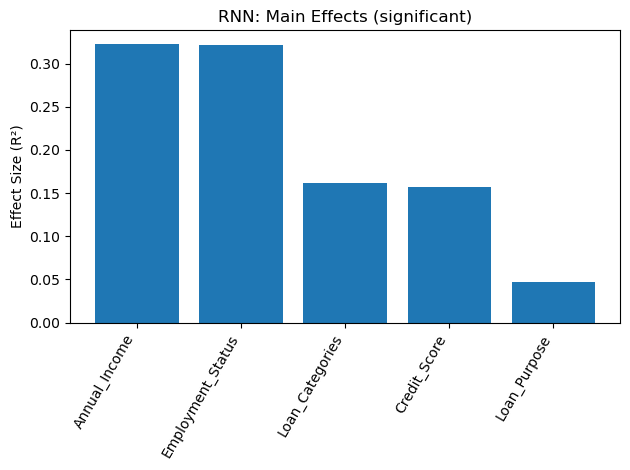

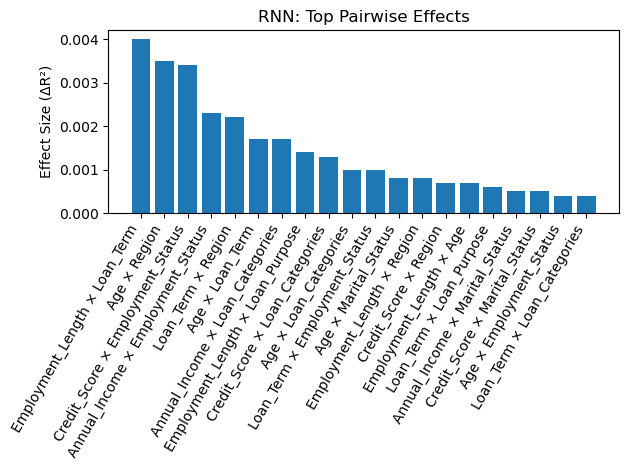

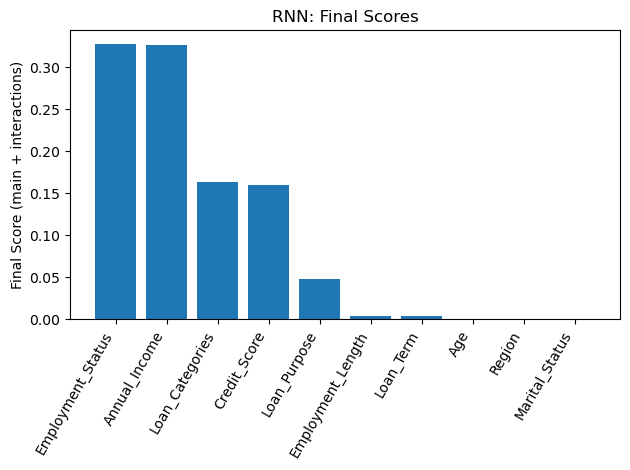

In [9]:

# STAT-XAI (Regression)
for col in CATEGORICAL_FEATURES:
    if col in merged_df.columns: merged_df[col]=merged_df[col].astype('category')
alpha=0.05; numeric_features=NUMERIC_FEATURES; categorical_features=CATEGORICAL_FEATURES; target="Predicted_Label"
main_records=[]; main_effects={}

for feat in numeric_features:
    m=smf.ols(f"{target}~{feat}", merged_df).fit()
    p=m.pvalues.get(feat, np.nan); r2=m.rsquared; eff=r2 if (not np.isnan(p) and p<alpha) else 0.0
    main_effects[feat]=eff; main_records.append({'Feature':feat,'Type':'Numeric','p-value':round(float(p),4) if not np.isnan(p) else np.nan,'Effect Size (R²)':round(float(eff),4)})
for feat in categorical_features:
    m=smf.ols(f"{target}~C({feat})", merged_df).fit()
    p=m.f_pvalue; r2=m.rsquared; eff=r2 if (not np.isnan(p) and p<alpha) else 0.0
    main_effects[feat]=eff; main_records.append({'Feature':feat,'Type':'Categorical','p-value':round(float(p),4) if not np.isnan(p) else np.nan,'Effect Size (R²)':round(float(eff),4)})
main_df=pd.DataFrame(main_records).sort_values('Effect Size (R²)', ascending=False).reset_index(drop=True)
main_df.to_csv(os.path.join(TABLES_DIR, f"main_effects_{MODEL_SUFFIX}.csv"), index=False)
display(main_df)

interaction_records=[]; pair_effects={feat:0.0 for feat in (numeric_features+categorical_features)}
for f1,f2 in itertools.combinations(numeric_features+categorical_features,2):
    is1=f1 in numeric_features; is2=f2 in numeric_features
    t1=f1 if is1 else f"C({f1})"; t2=f2 if is2 else f"C({f2})"
    if is1 and is2:
        full=smf.ols(f"{target}~{t1}*{t2}", merged_df).fit(); red=smf.ols(f"{target}~{t1}+{t2}", merged_df).fit()
        p=full.pvalues.get(f"{f1}:{f2}", np.nan); eff=full.rsquared-red.rsquared; eff_col='Effect Size (ΔR²)'
    elif (not is1) and (not is2):
        mod=smf.ols(f"{target}~{t1}*{t2}", merged_df).fit(); aov=sm.stats.anova_lm(mod, typ=2)
        p=aov.loc[f"{t1}:{t2}","PR(>F)"]; ss_int=aov.loc[f"{t1}:{t2}","sum_sq"]; ss_err=aov.loc["Residual","sum_sq"]
        eff=float(ss_int/(ss_int+ss_err)) if (ss_int+ss_err)>0 else 0.0; eff_col='Effect Size (ηp²)'
    else:
        num_f=f1 if is1 else f2; cat_f=f2 if is1 else f1
        full=smf.ols(f"{target}~{num_f}*C({cat_f})", merged_df).fit(); red=smf.ols(f"{target}~{num_f}+C({cat_f})", merged_df).fit()
        aov=sm.stats.anova_lm(red, full); p=aov["Pr(>F)"].iloc[1]; eff=full.rsquared-red.rsquared; eff_col='Effect Size (ΔR²)'
    interaction_records.append({'Feature Pair':f"{f1} × {f2}",'p-value':round(float(p),4) if not np.isnan(p) else np.nan, eff_col:round(float(eff),4)})
    if (not np.isnan(p)) and p<alpha: pair_effects[f1]+=eff; pair_effects[f2]+=eff

pairwise_df=pd.DataFrame(interaction_records); pairwise_df.to_csv(os.path.join(TABLES_DIR, f"pairwise_interactions_{MODEL_SUFFIX}.csv"), index=False)
display(pairwise_df)

final_records=[]
for feat in numeric_features+categorical_features:
    main_r2=main_effects.get(feat,0.0); sum_int=pair_effects.get(feat,0.0)
    final_records.append({'Feature':feat,'Main Effect (R²)':round(float(main_r2),4),'Sum Interaction':round(float(sum_int),4),'Final Score':round(float(main_r2+sum_int),4)})
final_df=pd.DataFrame(final_records).sort_values('Final Score', ascending=False).reset_index(drop=True)
final_df.to_csv(os.path.join(TABLES_DIR, f"final_scores_{MODEL_SUFFIX}.csv"), index=False)
display(final_df)

# Plots
df_sorted=main_df.sort_values('Effect Size (R²)', ascending=False); filtered=df_sorted[df_sorted['p-value']<0.05]
plt.figure(); plt.bar(filtered['Feature'], filtered['Effect Size (R²)']); plt.xticks(rotation=60, ha='right'); plt.ylabel('Effect Size (R²)')
plt.title(f'{MODEL_SUFFIX}: Main Effects (significant)'); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,f"main_effects_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()

pair_col='Effect Size (ΔR²)' if 'Effect Size (ΔR²)' in pairwise_df.columns else 'Effect Size (ηp²)'
top=pairwise_df.dropna(subset=[pair_col]).sort_values(pair_col, ascending=False).head(20)
plt.figure(); plt.bar(top['Feature Pair'], top[pair_col]); plt.xticks(rotation=60,ha='right'); plt.ylabel(pair_col)
plt.title(f'{MODEL_SUFFIX}: Top Pairwise Effects'); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,f"pairwise_effects_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()

plt.figure(); plt.bar(final_df['Feature'], final_df['Final Score']); plt.xticks(rotation=60,ha='right'); plt.ylabel('Final Score (main + interactions)')
plt.title(f'{MODEL_SUFFIX}: Final Scores'); plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR,f"final_effects_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
